In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib
import matplotlib.pyplot as plt
from pandasql import sqldf
%matplotlib inline

In [2]:
#Importing data for analysis
sf_neighborhoods ="https://data.sfgov.org/api/geospatial/p5b7-5n3h?method=export&format=Shapefile"
sf_meters = "https://data.sfgov.org/api/views/8vzz-qzz9/rows.csv?accessType=DOWNLOAD"

In [22]:
#reading shape files and crating pandas dataframes
nhood_shape=gpd.read_file(sf_neighborhoods)
#reading CSVs
meters = pd.read_csv(sf_meters)

<AxesSubplot:>

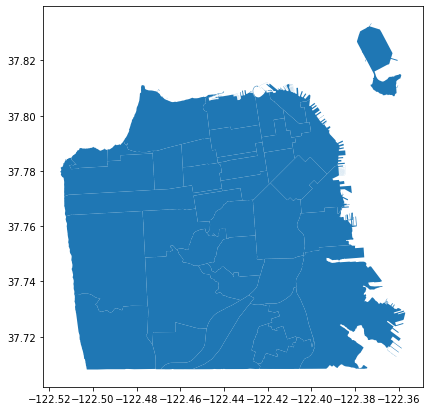

In [5]:
#looking at the data
nhood_shape.plot(figsize=(7,7))

In [7]:
nhood_shape.head()

,nhood,geometry
0,Bayview Hunters Point,"POLYGON ((-122.38158 37.75307, -122.38157 37.7..."
1,Bernal Heights,"POLYGON ((-122.40361 37.74934, -122.40378 37.7..."
2,Castro/Upper Market,"POLYGON ((-122.42656 37.76948, -122.42695 37.7..."
3,Chinatown,"POLYGON ((-122.40623 37.79756, -122.40551 37.7..."
4,Excelsior,"POLYGON ((-122.42398 37.73155, -122.42392 37.7..."


In [6]:
meters.head()

,OBJECTID,PARKING_SPACE_ID,POST_ID,MS_PAY_STATION_ID,MS_SPACE_NUM,SENSOR_FLAG,ON_OFFSTREET_TYPE,OSP_ID,JURISDICTION,PM_DISTRICT_ID,...,NFC_KEY,SPT_CODE,COLLECTION_ROUTE_DESC,COLLECTION_SUBROUTE_DESC,shape,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,5228201,101400,500-08020,-,0,N,ON,0.0,SFMTA,12.0,...,6325,NaN,NaN,NaN,POINT (-122.408394 37.79584),104,104,6,3,6
1,5228280,102036,419-13290,-,0,N,ON,0.0,SFMTA,15.0,...,9EPC,NaN,Franklin St: Unit - 900,Franklin 1200-1500,POINT (-122.423454 37.7872),100,100,4,6,39
2,5229090,109966,671-01050,671-01001,5,Y,ON,0.0,SFMTA,2.0,...,8JGP,NaN,NaN,NaN,POINT (-122.39461 37.780937),31,31,1,10,8
3,5229183,104916,606-15400,-,0,N,ON,0.0,SFMTA,15.0,...,6X57,NaN,NaN,NaN,POINT (-122.42171 37.789528),105,105,4,3,21
4,5229690,107918,418-06100,-,0,E,ON,0.0,SFMTA,2.0,...,3NBT,NaN,NaN,NaN,POINT (-122.397156 37.785294),32,32,1,10,8


In [10]:
#which meters are in hunters point / Bay View
bv_shape = nhood_shape[nhood_shape['nhood']=="Bayview Hunters Point"]
bv_shape.head()

,nhood,geometry
0,Bayview Hunters Point,"POLYGON ((-122.38158 37.75307, -122.38157 37.7..."


In [66]:
#setting crs
bv_shape['geometry'] = bv_shape['geometry'].set_crs("EPSG:4326",allow_override=True)

In [44]:
bv_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   nhood     1 non-null      object  
 1   geometry  1 non-null      geometry
dtypes: geometry(1), object(1)
memory usage: 24.0+ bytes


In [90]:
#just taking necessary fields from meters df
meters_filter = meters[['POST_ID', 'shape','Analysis Neighborhoods']].copy()

In [91]:
#turning meters_filter into a geodataframe
meters_gpd = gpd.GeoDataFrame(meters_filter)

In [92]:
#casting as geometry
meters_gpd['shape'] = gpd.GeoSeries.from_wkt(meters_gpd['shape'])

In [93]:
#setting crs
meters_gpd['shape'] = meters_gpd['shape'].set_crs("EPSG:4326")

In [94]:
#checking to see if we have geometry
meters_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34329 entries, 0 to 34328
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   POST_ID                 34329 non-null  object  
 1   shape                   34329 non-null  geometry
 2   Analysis Neighborhoods  34329 non-null  int64   
dtypes: geometry(1), int64(1), object(1)
memory usage: 804.7+ KB


In [95]:
meters_gpd['bayview'] = meters_gpd['shape'].map(lambda x: True if bv_shape.contains(x).any()==True else False)

In [97]:
meters_gpd.head(100)

,POST_ID,shape,Analysis Neighborhoods,bayview
0,500-08020,POINT (-122.40839 37.79584),6,False
1,419-13290,POINT (-122.42345 37.78720),39,False
2,671-01050,POINT (-122.39461 37.78094),8,False
3,606-15400,POINT (-122.42171 37.78953),21,False
4,418-06100,POINT (-122.39716 37.78529),8,False
...,...,...,...,...
95,593-09280,POINT (-122.42058 37.78489),36,False
96,585-03220,POINT (-122.41296 37.80672),23,False
97,333-15110,POINT (-122.40115 37.72477),1,True
98,500-07150,POINT (-122.40713 37.79592),6,False


In [98]:
meters_bv = meters_gpd[[]'bayview']==False

In [99]:
meters_bv.head()

0    True
1    True
2    True
3    True
4    True
Name: bayview, dtype: bool